In [1]:
!git clone https://github.com/theschoolofai/YoloV3.git

Cloning into 'YoloV3'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 12.74 MiB | 45.00 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


In [66]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [14]:
!ls -altrh drive/My\ Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip

-r-------- 1 root root 265M Oct 22 11:19 'drive/My Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip'


### Custom dataset - Setup appropriate files for training

In [ ]:
!unzip drive/My\ Drive/EVA/Datasets/YoloV3-PPE/YoloV3_Dataset.zip

In [60]:
%%shell
srcFolder="YoloV3_Dataset"
targetDataFolder="YoloV3/data/ppedata/"
mkdir -p $targetDataFolder
# create ppe.data file
cat > $targetDataFolder/ppe.data <<EOF
classes=4
train=data/ppedata/ppetrain.txt
valid=data/ppedata/ppetest.txt 
names=data/ppedata/ppe.names
EOF

# copy required files from dataset
cp $srcFolder/classes.txt $targetDataFolder/ppe.names
mkdir -p images && cp $srcFolder/Images/* $targetDataFolder/images/
mkdir -p labels && cp $srcFolder/Labels/* $targetDataFolder/labels/
# Make sure any decimals around 1 i.e 1.xxxxx should be rounded off to 1.0
sed -i 's/1\.[0-9]*/1.0/g'  $targetDataFolder/labels/*

echo "> ppe.data"
cat $targetDataFolder/ppe.data

echo ""; echo "> ppe.names"
cat $targetDataFolder/ppe.names; echo""

> ppe.data
classes=4
train=data/ppedata/ppetrain.txt
valid=data/ppedata/ppetest.txt 
names=data/ppedata/ppe.names

> ppe.names
hardhat
vest
mask
boots


#### Split train/test images (9:1) based of Labels

In [37]:
import re
import os
import imagesize

srcFolder="YoloV3_Dataset"
targetDataFolder="YoloV3/data/ppedata"
trainFile = open(f'{targetDataFolder}/ppetrain.txt', 'w')
testFile = open(f'{targetDataFolder}/ppetest.txt', 'w')
trainShapesFile = open(f'{targetDataFolder}/ppetrain.shapes', 'w')
testShapesFile = open(f'{targetDataFolder}/ppetest.shapes', 'w')
labelFiles = os.listdir(srcFolder + "/Labels")
imgFiles = os.listdir(srcFolder + "/Images")
count = 0
testCnt = len(labelFiles)/10
trainCnt = len(labelFiles) - testCnt
for file in labelFiles:
  imgParts = file.split(".txt")
  r = re.compile(re.escape(imgParts[0])+".*")
  found = False
  for imgFile in imgFiles:
    if r.match(imgFile):
      shape = imagesize.get(f'{srcFolder}/Images/{imgFile}')
      if count < trainCnt:
        trainFile.write(f'./data/ppedata/images/{imgFile}\n')
        if shape: trainShapesFile.write(f'{shape[0]} {shape[1]}\n')
      else:
        testFile.write(f'./data/ppedata/images/{imgFile}\n')
        if shape: testShapesFile.write(f'{shape[0]} {shape[1]}\n')
      count+=1
      found = True
      break
trainFile.close()
testFile.close()
trainShapesFile.close()
testShapesFile.close()

!echo "Total train images: $(cat YoloV3/data/ppedata/ppetrain.txt | wc -l)"
!echo "Total train image shapes: $(cat YoloV3/data/ppedata/ppetrain.shapes | wc -l)"
!echo "Top 5 lines of train file: $(head -n 5 YoloV3/data/ppedata/ppetrain.txt)"
!echo "";
!echo "Total test images: $(cat YoloV3/data/ppedata/ppetest.txt | wc -l)"
!echo "Total test image shapes: $(cat YoloV3/data/ppedata/ppetest.shapes | wc -l)"
!echo "Top 5 lines of test file: $(head -n 5 YoloV3/data/ppedata/ppetest.txt)"

Total train images: 3174
Total train image shapes: 3174
Top 5 lines of train file: ./data/ppedata/images/a32.jpg
./data/ppedata/images/portrait-of-a-man-using-pm-25-pollution-mask-in-the-street-of-a-big-picture-id1146047559.jpg
./data/ppedata/images/portrait-of-woman-with-medical-mask-standing-on-road-in-city-epidemic-picture-id1213279564.jpg
./data/ppedata/images/z042 .jpg
./data/ppedata/images/Aimg_062.jpg

Total test images: 347
Total test image shapes: 347
Top 5 lines of test file: ./data/ppedata/images/HV_010.jpg
./data/ppedata/images/E79.jpg
./data/ppedata/images/E82.jpg
./data/ppedata/images/Aimg_055.jpg
./data/ppedata/images/Q16.jpg


#### Change architecture based on Dataset
* For COCO's 80 classes, YOLOv3's output vector has 255 dimensions ( (4+1+80)*3)* Now we have 4 class, so we would need to change it's architecture.

In [40]:
%%shell
# Copy the contents of 'yolov3-spp.cfg' file to a new file called 'yolov3-ppe.cfg' file in the data/cfg folder.
cp YoloV3/cfg/yolov3-spp.cfg YoloV3/cfg/yolov3-ppe.cfg

# Search for 'filters=255' (you should get entries entries). Change 255 to *27* = (4+1+4)*3
sed -i 's/filters=255/filters=27/g' YoloV3/cfg/yolov3-ppe.cfg

# Search for 'classes=80' and change all three entries to 'classes=4'
sed -i 's/classes=80/classes=4/g' YoloV3/cfg/yolov3-ppe.cfg

# Verify if changes took place successfully
grep "filters=27" YoloV3/cfg/yolov3-ppe.cfg
grep "classes" YoloV3/cfg/yolov3-ppe.cfg

filters=27
filters=27
filters=27

classes=4
classes=4
classes=4



#### Download model weights

In [41]:
# Create a folder called weights in the root (YoloV3) folder
!mkdir -p YoloV3/weights
!cp drive/My\ Drive/EVA/Models/yolov3-spp-ultralytics.pt YoloV3/weights/

In [57]:
!cd YoloV3/; ls weights; ls data/ppedata

yolov3-spp-ultralytics.pt
images	ppe.data   ppe.shapes	   ppetest.txt	    ppetrain.txt
labels	ppe.names  ppetest.shapes  ppetrain.shapes


#### Perform training

In [97]:
# Prevent Colab Random Disconnects
import IPython
from google.colab import output
display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button");
     btn.click()
     }
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect");
     btn.click()
     }
  }
setInterval(ClickConnect,60000)
'''))
print("Done.")

<IPython.core.display.Javascript object>

Done.


In [61]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --cfg cfg/yolov3-ppe.cfg --batch 3 --cache --epochs 3 --nosave


Namespace(accumulate=4, adam=False, batch_size=3, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=3, evolve=False, img_size=[512], multi_scale=False, name='', nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-24 10:09:51.963412: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:00<00:00, 8221.66it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 149.66it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<00:0

In [100]:
!cd YoloV3; python train.py --data data/ppedata/ppe.data --batch 10 --cache --cfg cfg/yolov3-ppe.cfg --epochs 50

Namespace(accumulate=4, adam=False, batch_size=10, bucket='', cache_images=True, cfg='cfg/yolov3-ppe.cfg', data='data/ppedata/ppe.data', device='', epochs=50, evolve=False, img_size=[512], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-24 11:13:26.817736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Run 'tensorboard --logdir=runs' to view tensorboard at http://localhost:6006/
Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
Caching labels (2992 found, 137 missing, 45 empty, 0 duplicate, for 3174 images): 100% 3174/3174 [00:00<00:00, 8070.28it/s]
Caching images (1.8GB): 100% 3174/3174 [00:21<00:00, 150.90it/s]
Caching labels (333 found, 10 missing, 4 empty, 0 duplicate, for 347 images): 100% 347/347 [00:00<0

#### Download sample video containing our classes

In [108]:
%%shell
wget https://github.com/ashxjain/eva/raw/master/P5_S13/sample_videos/video1.mp4
mkdir -p YoloV3/data/source_imgs
mv video1.mp4 YoloV3/data/source_imgs/
cd YoloV3/data/source_imgs; ffmpeg -i video1.mp4 -r 10 %03d.jpg

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

#### Get annotations on the input video frames

In [90]:
!cd YoloV3; python detect.py --conf-thres 0.1 --cfg cfg/yolov3-ppe.cfg --names data/ppedata/ppe.names --source source_imgs --output out_imgs

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3-ppe.cfg', classes=None, conf_thres=0.1, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='data/ppedata/ppe.names', output='out_out', save_txt=False, source='input_imgs', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Model Summary: 225 layers, 6.25895e+07 parameters, 6.25895e+07 gradients
image 1/132 input_imgs/001.jpg: 320x512 4 hardhats, 3 vests, 3 masks, Done. (0.033s)
image 2/132 input_imgs/002.jpg: 320x512 5 hardhats, 4 vests, 2 masks, Done. (0.033s)
image 3/132 input_imgs/003.jpg: 320x512 5 hardhats, 3 vests, 2 masks, Done. (0.033s)
image 4/132 input_imgs/004.jpg: 320x512 4 hardhats, 3 vests, 2 masks, Done. (0.021s)
image 5/132 input_imgs/005.jpg: 320x512 5 hardhats, 3 vests, 2 masks, Done. (0.021s)
image 6/132 input_imgs/006.jpg: 320x512 5 hardhats, 4 vests, 3 masks, Done. (0.021s)
image 7/132 input_imgs/007.jpg: 320x51

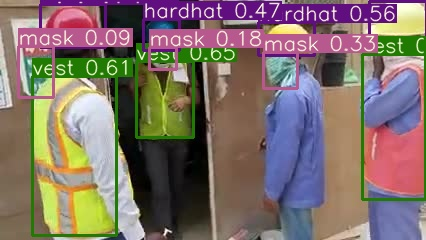

In [91]:
Image(filename='YoloV3/out_imgs/001.jpg', width=600)

#### Merge frames and convert it to video

In [92]:
!ffmpeg -r 10 -i YoloV3/out_imgs/%03d.jpg annotated_video.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib